# Monitoria 02 - parte 02




2.1 Instalação de pacotes adicionais

In [ ]:
!pip install dfply
!pip install scikit-plot
!pip install graphviz
!pip install dtreeviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 612 kB 4.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 619 kB/s 


2.2 Importação de bibliotecas

In [ ]:
import pandas as pd # para processamento de bancos de dados
import numpy as np # para processamento numérico de bancos de dados
import matplotlib # para geração de gráficos
import matplotlib.pyplot as plt # configurações adicionais para os gráficos a serem gerados

# informamos ao Python que estamos usando um notebook e que os gráficos devem ser exibidos nele
%matplotlib inline

import seaborn as sns #alternativa para a matplotlib para geração de gráficos

# SCIKIT-LEARN
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from dfply import *  # para importar os comandos da biblioteca dfply

import scikitplot as skplt

from dtreeviz.trees import *

import warnings # ignorando os warnings emitidos pelo Python
warnings.filterwarnings("ignore")

# configurações adicionais de figuras
plt.rcParams["figure.figsize"] = [10, 5]
plt.style.use("fivethirtyeight")
%config InlineBackend.figure_format = 'retina'
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':10})
rc('mathtext',**{'default':'regular'})

np.random.seed(42)  # semente de aleatoriedade

3. Obtendo o conjunto de dados

In [ ]:
dataset = pd.read_csv('https://raw.githubusercontent.com/laderast/cvdRiskData/master/data-raw/fullPatientData.csv')

3.1 Verificando o conjunto de dados

In [ ]:
dataset.shape

(425195, 13)

In [ ]:
dataset.head(5)

,patientID,age,htn,treat,smoking,race,t2d,gender,numAge,bmi,tchol,sbp,cvd
0,HHUID00076230,20-40,Y,Y,N,Asian/PI,N,M,21,26,176,179,N
1,HHUID00547835,70-90,N,N,N,White,N,M,86,23,244,123,N
2,HHUID00450841,20-40,Y,Y,N,White,N,M,29,22,189,165,N
3,HHUID00380788,20-40,Y,Y,N,White,N,M,24,24,218,172,N
4,HHUID00043423,20-40,N,N,N,Asian/PI,N,M,40,20,207,111,N


4. Preparação do conjunto de dados

4.1 Filtrando o conjunto de dados

Para os modelos preditivos a serem desenvolvidos, iremos considerar individuos com idade superior a 55 anos.
Removeremos também as variáveis "patientID", "age" e "treat"

In [ ]:
cvd_data = (dataset >>
               mask(X.numAge > 55) >>
               drop(X.patientID, X.age, X.treat)
              )

In [ ]:
cvd_data.head(5)

,htn,smoking,race,t2d,gender,numAge,bmi,tchol,sbp,cvd
1,N,N,White,N,M,86,23,244,123,N
7,N,N,White,N,M,59,23,178,113,N
10,N,N,Asian/PI,N,M,69,19,181,118,N
11,Y,Y,White,N,M,56,21,188,183,N
12,N,N,White,N,M,64,16,240,111,N


In [ ]:
cvd_data.shape

(125335, 10)

4.2 Para as variáveis categóricas iremos criar dummies

In [ ]:
cvd_data = pd.get_dummies(cvd_data, columns=['htn', 'smoking', 't2d', 'gender', 'race'])

In [ ]:
cvd_data.head(10).T

,1,7,10,11,12,32,33,35,36,37
numAge,86,59,69,56,64,66,82,56,58,80
bmi,23,23,19,21,16,22,20,16,16,23
tchol,244,178,181,188,240,241,206,245,244,207
sbp,123,113,118,183,111,140,204,123,179,124
cvd,N,N,N,N,N,Y,Y,N,N,N
htn_N,1,1,1,0,1,1,0,1,0,1
htn_Y,0,0,0,1,0,0,1,0,1,0
smoking_N,1,1,1,0,1,1,1,1,1,1
smoking_Y,0,0,0,1,0,0,0,0,0,0
t2d_N,1,1,1,1,1,1,1,1,1,1


5. Conjuntos de treino e teste

In [ ]:
variaveis_preditoras = cvd_data.iloc[:, cvd_data.columns != 'cvd']
classe = cvd_data.iloc[:, cvd_data.columns == 'cvd']
X_train, X_test, y_train, y_test = train_test_split(variaveis_preditoras,
                                                    classe,
                                                    train_size = 0.70,
                                                    random_state = 42)

In [ ]:
X_train.columns

Index(['numAge', 'bmi', 'tchol', 'sbp', 'htn_N', 'htn_Y', 'smoking_N',
       'smoking_Y', 't2d_N', 't2d_Y', 'gender_F', 'gender_M', 'race_AmInd',
       'race_Asian/PI', 'race_Black/AfAm', 'race_White'],
      dtype='object')

In [ ]:
# Standarscaler com passthrough tem um problema de ordenação das colunas. Quando aplicamos, ele fornce o resultado com as colunas padronizadas em primeiro, seguidas das demais colunas.
# Para resolver este problema, iremos ordenar as nossas colunas alocando as contínuas nas primeiras posições

X_train = X_train.loc[:,['numAge', 'bmi', 'tchol', 'sbp', # variaveis continuas
                          'htn_N', 'htn_Y', 'smoking_N','smoking_Y', 't2d_N', 't2d_Y', 'gender_F', 'gender_M', 'race_AmInd','race_Asian/PI', 'race_Black/AfAm', 'race_White']]
X_test = X_test.loc[:,['numAge', 'bmi', 'tchol', 'sbp', # variaveis continuas
                          'htn_N', 'htn_Y', 'smoking_N','smoking_Y', 't2d_N', 't2d_Y', 'gender_F', 'gender_M', 'race_AmInd','race_Asian/PI', 'race_Black/AfAm', 'race_White']]

X_train_columns = X_train.columns
X_test_columns = X_test.columns

5.1 As variáveis contínuas serão padronizadas

In [ ]:
from sklearn.compose import ColumnTransformer

### variáveis contínuas que serão padronizadas
continuous_cols = ['numAge', 'bmi', 'tchol', 'sbp']

def setScaler():
  ct = ColumnTransformer([
        ('scaler', StandardScaler(), continuous_cols)
    ], remainder='passthrough' # utilizamos para manter as colunas em que não aplicamos o scaler
  )
  return ct

scaler = setScaler()


In [ ]:
scaler.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('scaler', StandardScaler(),
                                 ['numAge', 'bmi', 'tchol', 'sbp'])])

In [ ]:
X_train = scaler.transform(X_train)

In [ ]:
X_test = scaler.transform(X_test)

In [ ]:
# para evitarmos a exibição dos dados em notacao científica
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [ ]:
pd.DataFrame(X_train, columns=X_train_columns).describe().T

,count,mean,std,min,25%,50%,75%,max
numAge,87734.00,0.00,1.00,-1.30,-0.77,-0.23,0.63,2.35
bmi,87734.00,-0.00,1.00,-1.58,-0.66,-0.21,0.48,3.21
tchol,87734.00,0.00,1.00,-1.13,-0.96,-0.25,0.70,1.91
sbp,87734.00,-0.00,1.00,-2.13,-0.92,-0.32,0.97,2.24
htn_N,87734.00,0.52,0.50,0.00,0.00,1.00,1.00,1.00
htn_Y,87734.00,0.48,0.50,0.00,0.00,0.00,1.00,1.00
smoking_N,87734.00,0.87,0.34,0.00,1.00,1.00,1.00,1.00
smoking_Y,87734.00,0.13,0.34,0.00,0.00,0.00,0.00,1.00
t2d_N,87734.00,0.93,0.25,0.00,1.00,1.00,1.00,1.00
t2d_Y,87734.00,0.07,0.25,0.00,0.00,0.00,0.00,1.00


In [ ]:
# transformando Y --> 1 e N --> 0
le = preprocessing.LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)


In [ ]:
y_train

array([1, 1, 0, ..., 0, 0, 0])

## 6. Função auxiliar RunModel

In [ ]:
# Criando uma função para obtenção dos principais indicadores de performance do modelo
def runModel(model, X_train, y_train, X_test, y_test, confusion_matrix=True, normalizeCM=False, roc=True, plot_calibration=True, random_state=42, title="", pos_label=1):
    """Função auxiliar para execução de modelos de classificação.

    Parâmetros:

    - model: modelo de classificação a ser executado
    - X_train: base de treinamento das variáveis preditoras
    - y_train: base de treinamento da classe
    - X_test: base de teste das variáveis preditoras
    - y_test: base de teste da classe
    - confusion_matrix (default: True): exibir a matriz de confusão da classificação
    - normalizeCM (default: False): define se a matriz de confusão será normalizada
    - roc (default: True): define se será exibida a curva ROC para o classificador
    - plot_calibration (default: True): define se será exibida a curva de calibração para o classificador
    - title: define o título a ser exibido nos gráficos
    - pos_label: indica qual o valor de y_train e y_test que representa a classe positiva. O valor default é 1.

    """
    clf = model
    name = title
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)
    else:  # usar decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    if confusion_matrix:
       skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=normalizeCM, title=name)
    if roc:
       skplt.metrics.plot_roc(y_test, prob_pos, plot_micro=False, plot_macro=False, classes_to_plot=[1], title=name,figsize=(10,10))


    prob_pos = prob_pos[:,1]
    clf_score = brier_score_loss(y_test, prob_pos, pos_label=pos_label)
    print("%s:" % name)
    print("\tBrier: %1.3f" % (clf_score))
    print("\tROC(AUC) %1.3f" % roc_auc_score(y_test, prob_pos))
    print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
    print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
    print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))

    if plot_calibration:

      fraction_of_positives, mean_predicted_value = \
                calibration_curve(y_test, prob_pos, n_bins=10)
      plt.rcParams.update({'font.size': 22})
      plt.rc('legend',**{'fontsize':22})
      fig = plt.figure(3, figsize=(10, 10))
      ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
      ax2 = plt.subplot2grid((3, 1), (2, 0))
      ax1.plot([0, 1], [0, 1], "k:", label="Perfeitamente calibrado",)
      ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                     label="%s (%1.3f)" % (name, clf_score))

      ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                     histtype="step", lw=2)

      ax1.set_ylabel("Fração de positivos")
      ax1.set_ylim([-0.05, 1.05])
      ax1.legend(loc="lower right")
      ax1.set_title('Gráfico de Calibração  (reliability curve)')

      ax2.set_xlabel("Valor médio predito")
      ax2.set_ylabel("Quantidade")
      ax2.legend(loc="upper center", ncol=2)

      for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] +
             ax1.get_xticklabels() + ax1.get_yticklabels()):
        item.set_fontsize(22)

      for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
             ax2.get_xticklabels() + ax2.get_yticklabels()):
        item.set_fontsize(22)

      plt.tight_layout()
      plt.show()

In [ ]:
# Função de best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [ ]:
help(runModel)

Help on function runModel in module __main__:

runModel(model, X_train, y_train, X_test, y_test, confusion_matrix=True, normalizeCM=False, roc=True, plot_calibration=True, random_state=42, title='', pos_label=1)
    Função auxiliar para execução de modelos de classificação.
    
    Parâmetros:
    
    - model: modelo de classificação a ser executado
    - X_train: base de treinamento das variáveis preditoras
    - y_train: base de treinamento da classe
    - X_test: base de teste das variáveis preditoras
    - y_test: base de teste da classe
    - confusion_matrix (default: True): exibir a matriz de confusão da classificação
    - normalizeCM (default: False): define se a matriz de confusão será normalizada
    - roc (default: True): define se será exibida a curva ROC para o classificador
    - plot_calibration (default: True): define se será exibida a curva de calibração para o classificador
    - title: define o título a ser exibido nos gráficos
    - pos_label: indica qual o valor

---

### Execução dos algoritmos de machine learning

### Random Forest

In [ ]:
# modelo random forest
rf = RandomForestClassifier(random_state=42, verbose=1)

#### Otimização de hiperparâmetros

In [ ]:
np.random.seed(42)

# Número de árvores no Random Forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 5)]
# Número de features a serem consideradas a cada split
max_features = ['log2', 'sqrt']
# Número máximo de níveis na árvore
max_depth = [int(x) for x in np.linspace(5, 20, num = 5)]
# Número mínimo de amostras necessárias para dividir um nó
min_samples_split = [2, 5, 10]
# Número mínimo de amostras necessárias em cada leaf node
min_samples_leaf = [2, 4]
# Método de seleção das amostras para treinamento de cada árvore
bootstrap = [True, False]
# Criação do param grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Caso deseje rodar GridSearchCV, troque a linha abaixo pela que segue
#cv_rf = GridSearchCV(fit_rf, cv=3, param_grid=param_grid,n_jobs = -1)

cv_rf = RandomizedSearchCV(rf, n_iter=50, cv=3, verbose=1, param_distributions=param_grid,n_jobs = -1)

In [ ]:
# otimizando os hiperparâmetros
cv_rf.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 550 out of 550 | elapsed:   30.6s finished


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(random_state=42, verbose=1),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 8, 12, 16, 20],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 325, 550, 775,
                                                         1000]},
                   verbose=1)

In [ ]:
# melhores estimadores
rf = cv_rf.best_estimator_

In [ ]:
# modelo random forest otimizado
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=8, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=550,
                       n_jobs=None, oob_score=False, random_state=42, verbose=1,
                       warm_start=False)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 550 out of 550 | elapsed:   29.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 550 out of 550 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 550 out of 550 | elapsed:    2.8s finished


Random Forest:
	Brier: 0.163
	ROC(AUC) 0.774
	Precision: 0.647
	Recall: 0.325
	F1: 0.432



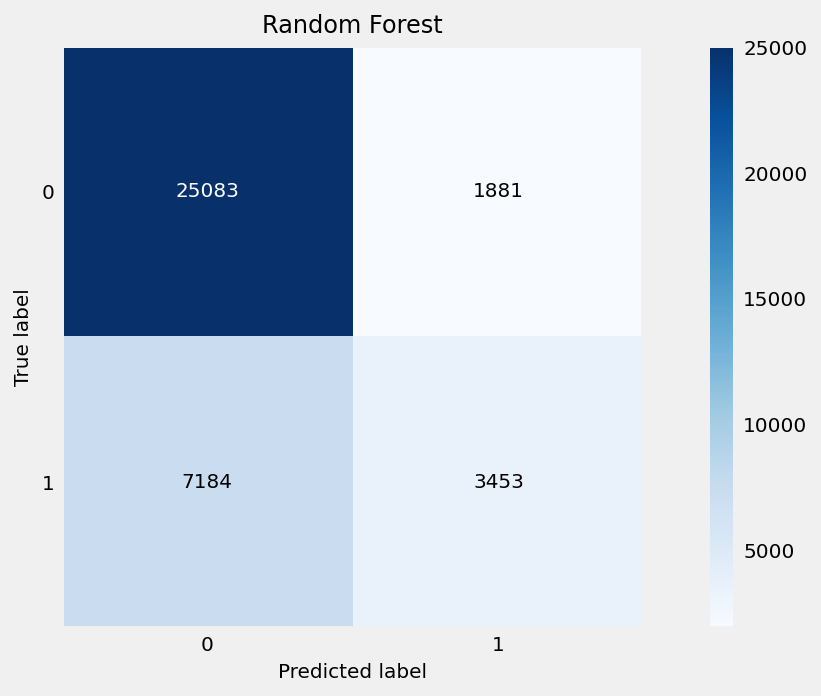

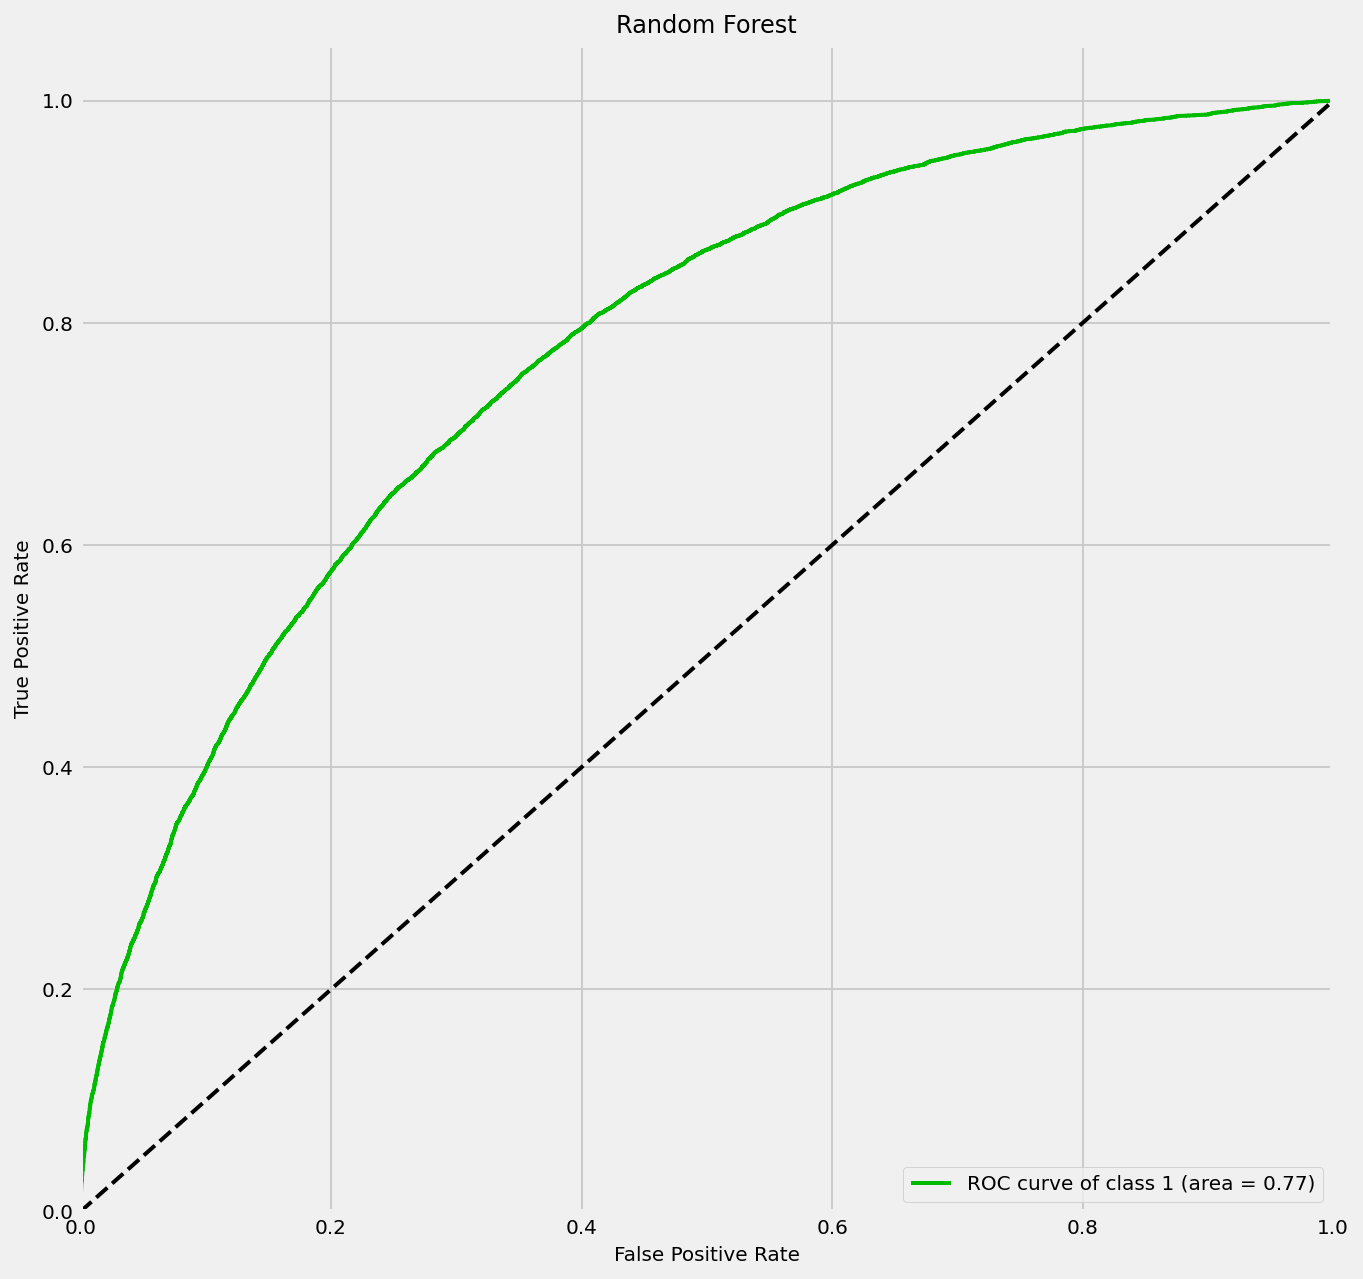

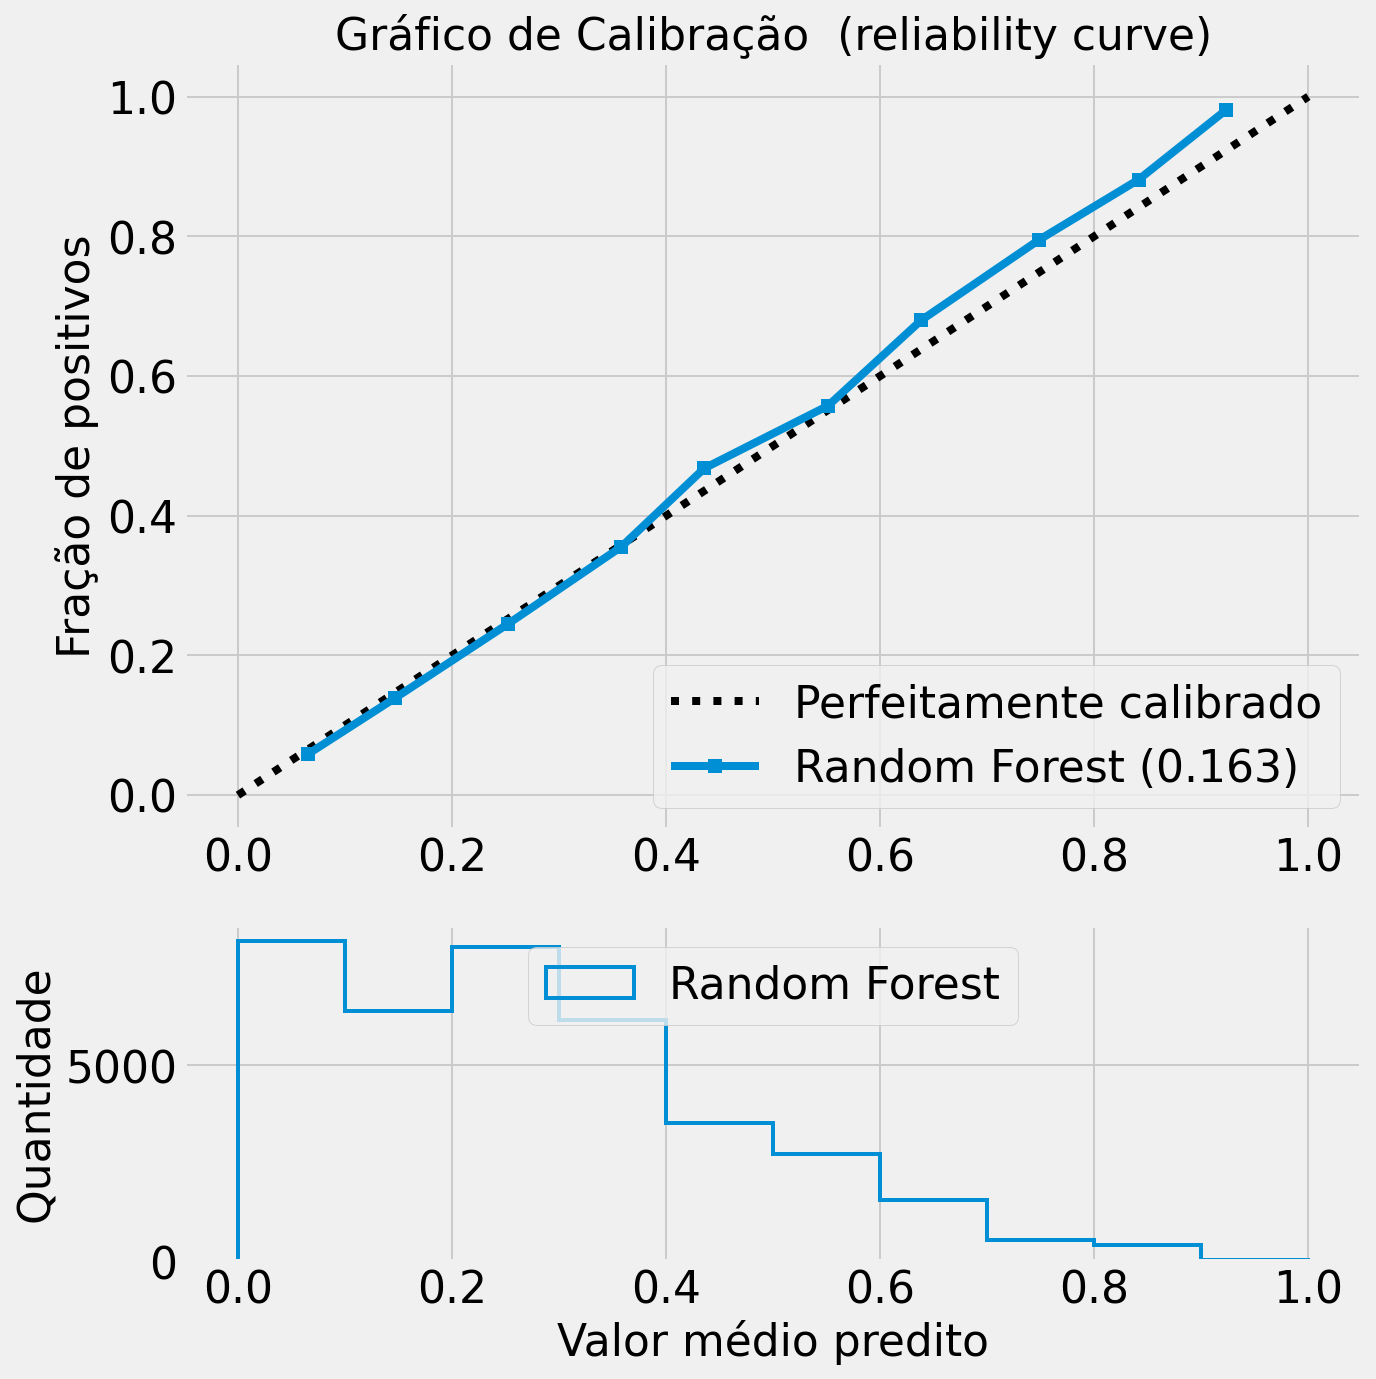

In [ ]:
# performance do modelo
runModel(rf, X_train, y_train, X_test, y_test, title="Random Forest")

In [ ]:
!pip install shap
import shap

     |████████████████████████████████| 564 kB 5.2 MB/s 


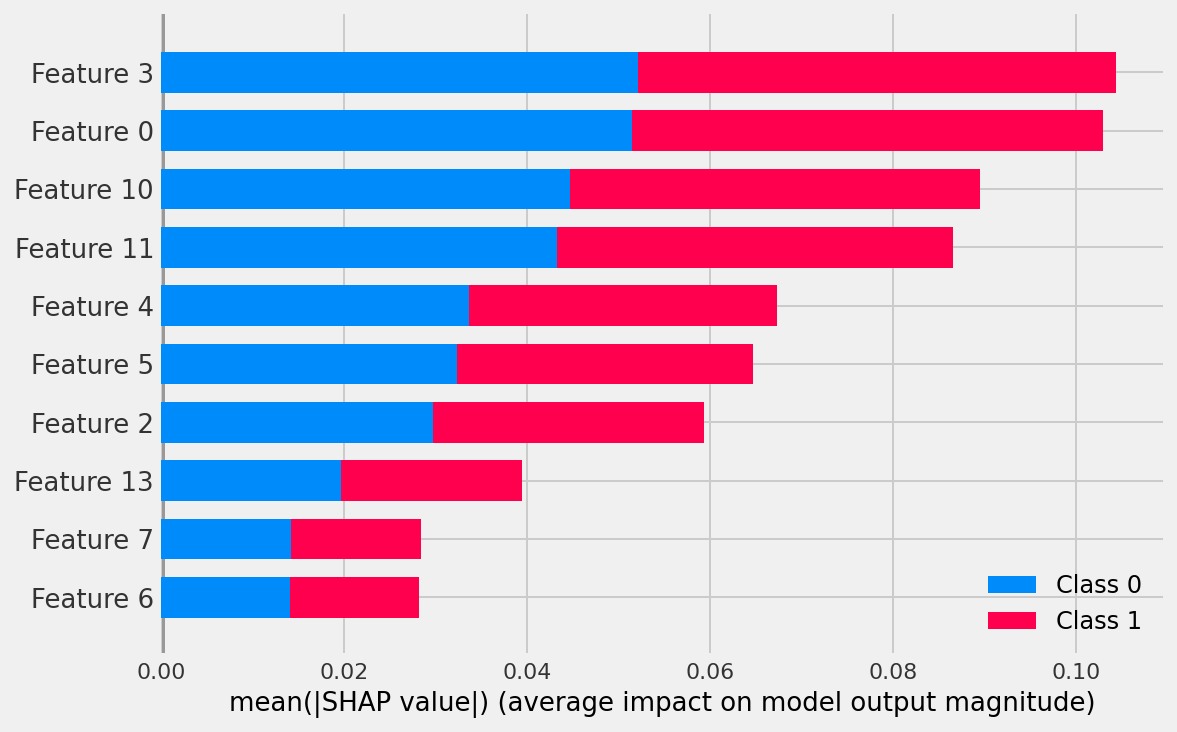

In [ ]:
# SHAP
shap_values = shap.TreeExplainer(rf).shap_values(X_test)
shap.summary_plot(shap_values, X_test, max_display=10, plot_type="bar")